In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import rankdata
from scipy import sparse
import matplotlib.pyplot as plt


In [14]:
data_path = "../data/raw/fraud_dataset_v1.csv"
df = pd.read_csv(data_path)

labels_orig = df["label"].values
df_features = df.drop(columns=["label"])


In [15]:
numeric_cols = df_features.select_dtypes(include=[np.number]).columns
categorical_cols = df_features.select_dtypes(include=[object]).columns

# Numeric
scaler = StandardScaler()
X_num = scaler.fit_transform(df_features[numeric_cols])

# Categorical (sparse)
if len(categorical_cols) > 0:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    X_cat = encoder.fit_transform(df_features[categorical_cols])
    X_sparse = sparse.hstack([sparse.csr_matrix(X_num), X_cat]).tocsr()
else:
    X_sparse = sparse.csr_matrix(X_num)

# Convert to dense ONCE (batch AE later)
X_dense = X_sparse.astype(np.float32).toarray()


In [16]:
dataset = TensorDataset(torch.from_numpy(X_dense))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=1024, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=1024, shuffle=False)


In [17]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        noise = torch.randn_like(x) * 0.01
        x_noisy = x + noise
        z = self.encoder(x_noisy)
        x_hat = self.decoder(z)
        return x_hat, z


In [18]:
ae = DenoisingAutoencoder(X_dense.shape[1], latent_dim=8)
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
criterion = nn.MSELoss()

best_val = np.inf
patience, counter = 5, 0
best_state = None

for epoch in range(50):
    ae.train()
    train_loss = 0
    for (x,) in train_loader:
        optimizer.zero_grad()
        x_hat, _ = ae(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    ae.eval()
    val_loss = 0
    with torch.no_grad():
        for (x,) in val_loader:
            x_hat, _ = ae(x)
            val_loss += criterion(x_hat, x).item() * x.size(0)

    train_loss /= train_size
    val_loss   /= val_size

    print(f"Epoch {epoch+1} | Train {train_loss:.6f} | Val {val_loss:.6f}")

    if val_loss < best_val:
        best_val = val_loss
        best_state = ae.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

ae.load_state_dict(best_state)


Epoch 1 | Train 0.004310 | Val 0.003543
Epoch 2 | Train 0.002264 | Val 0.001859
Epoch 3 | Train 0.001727 | Val 0.001501
Epoch 4 | Train 0.001411 | Val 0.001381
Epoch 5 | Train 0.001285 | Val 0.001241
Epoch 6 | Train 0.001237 | Val 0.001194
Epoch 7 | Train 0.001177 | Val 0.001139
Epoch 8 | Train 0.001151 | Val 0.001257
Epoch 9 | Train 0.001147 | Val 0.001162
Epoch 10 | Train 0.001064 | Val 0.001025
Epoch 11 | Train 0.001002 | Val 0.001008
Epoch 12 | Train 0.000974 | Val 0.000933
Epoch 13 | Train 0.001062 | Val 0.000900
Epoch 14 | Train 0.000872 | Val 0.000814
Epoch 15 | Train 0.000782 | Val 0.000801
Epoch 16 | Train 0.000736 | Val 0.000699
Epoch 17 | Train 0.000658 | Val 0.000623
Epoch 18 | Train 0.000607 | Val 0.000578
Epoch 19 | Train 0.000579 | Val 0.000528
Epoch 20 | Train 0.000506 | Val 0.000480
Epoch 21 | Train 0.000534 | Val 0.000462
Epoch 22 | Train 0.000444 | Val 0.000428
Epoch 23 | Train 0.000422 | Val 0.000406
Epoch 24 | Train 0.000396 | Val 0.000381
Epoch 25 | Train 0.000388

<All keys matched successfully>

In [19]:
ae.eval()
rec_error, latent = [], []

with torch.no_grad():
    for i in range(0, X_dense.shape[0], 1024):
        batch = torch.from_numpy(X_dense[i:i+1024])
        x_hat, z = ae(batch)
        rec_error.append(((batch - x_hat)**2).mean(dim=1).numpy())
        latent.append(z.numpy())

rec_error = np.concatenate(rec_error)
latent = np.concatenate(latent)


In [20]:
# Label mapping (ONLY for evaluation & LOF training)
label_map = {"regular": 0, "local": 1, "global": 1}
labels_numeric = np.array([label_map[l] if isinstance(l,str) else int(l) for l in labels_orig])

# ---- LOF (Local) ----
lof = LocalOutlierFactor(n_neighbors=15, novelty=True)
lof.fit(latent[labels_numeric == 0])
lof_score = -lof.decision_function(latent)

# ---- Isolation Forest (Global) ----
iforest = IsolationForest(
    n_estimators=300,
    contamination=0.01,
    random_state=42
)
iforest.fit(latent)
if_score = -iforest.score_samples(latent)


In [21]:
rec_rank = rankdata(rec_error)
lof_rank = rankdata(lof_score)
if_rank  = rankdata(if_score)

ensemble_rank = (
    0.3 * rec_rank +
    0.5 * lof_rank +   # local emphasis
    0.2 * if_rank
)

ensemble_rank /= ensemble_rank.max()


In [22]:
N = len(ensemble_rank)

# ---------- 1. GLOBAL anomalies  ----------
th_global = np.percentile(ensemble_rank, 99.85)
pred_global = ensemble_rank >= th_global


# ---------- 2. LOCAL anomalies ----------
# Normalize LOF rank
lof_rank_norm = lof_rank / lof_rank.max()

# Local threshold (strict)
th_local = np.percentile(lof_rank_norm, 99.7)

# Global gating (local anomalies should not be very normal globally)
th_global_gate = np.percentile(ensemble_rank, 97.0)

# Candidate local anomalies
pred_local_candidate = (
    (lof_rank_norm >= th_local) &
    (ensemble_rank >= th_global_gate)
)

# ---------- 3. Top-K constraint (unsupervised prior) ----------
K = int(0.003 * N)   # 0.3% of data

local_idx = np.where(pred_local_candidate)[0]
if len(local_idx) > K:
    # Keep only strongest LOF anomalies
    local_idx = local_idx[np.argsort(lof_rank_norm[local_idx])[-K:]]

pred_local = np.zeros(N, dtype=bool)
pred_local[local_idx] = True


# ---------- 4. FINAL decision ----------
preds = (pred_global | pred_local).astype(int)


In [23]:
print("Anomalies predicted:", preds.sum())
print("Precision:", precision_score(labels_numeric, preds))
print("Recall:", recall_score(labels_numeric, preds))
print("F1:", f1_score(labels_numeric, preds))
print("ROC-AUC:", roc_auc_score(labels_numeric, ensemble_rank))

print("\nDetected anomalies by type:")
print(df[preds==1]["label"].value_counts())


Anomalies predicted: 1500
Precision: 0.04666666666666667
Recall: 0.7
F1: 0.0875
ROC-AUC: 0.9745301543040181

Detected anomalies by type:
label
regular    1430
global       70
Name: count, dtype: int64


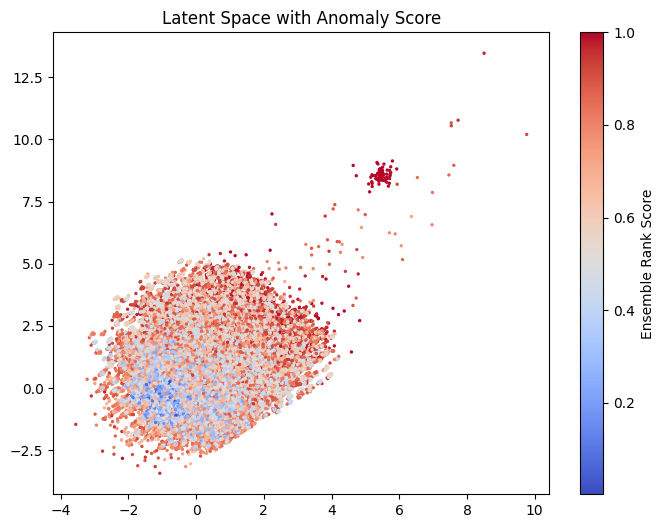

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(latent[:,0], latent[:,1],
            c=ensemble_rank, cmap="coolwarm", s=2)
plt.colorbar(label="Ensemble Rank Score")
plt.title("Latent Space with Anomaly Score")
plt.show()
